# <u>Neural Network using Tensorflow

### First we will have to import some libraries

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import math
from tensorflow.python.framework import ops
import time

%matplotlib inline

## <u>Problem Statement:
We are given pictures of hand signs taken from **SIGNS Dataset** where each picture shows a hand sign denoting a number from 0-5.
- **Training set**: pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).


## <u>Preprocessing Step</u>
### First we need to load the data


In [40]:
'''
Loads the data from the data set file
Arguments:
    nil
returns:
    train_X:(numpy array) contains the training features
    train_y:(numpy array) contains the correct labels for the training examples
    test_X:(numpy array) contains the test features
    test_y:(numpy array) contains the correct labels for the test examples
'''
def loadData():
    
    # load the train file
    train_data = h5py.File('datasets/train_signs.h5', "r")
    # load the training features 
    train_X = np.array(train_data['train_set_x'][:])
    # load the correct labels for training set
    train_y = np.array(train_data['train_set_y'][:])
    
    # load the test file
    test_data = h5py.File('datasets/test_signs.h5', "r")
    # load the test features 
    test_X = np.array(test_data['test_set_x'][:])
    # load the correct labels for test set
    test_y = np.array(test_data['test_set_y'][:])
    
    return train_X, train_y, test_X, test_y

In [41]:
#load the data
train_X, train_y, test_X, test_y = loadData()

#### First let us check the dimensions of the loaded data variables

In [42]:
print('Training set shape:'+ str(train_X.shape))
print('Training set shape:'+ str(train_y.shape))
print('Test set shape:'+ str(test_X.shape))
print('Test set shape:'+ str(test_y.shape))

Training set shape:(1080, 64, 64, 3)
Training set shape:(1080,)
Test set shape:(120, 64, 64, 3)
Test set shape:(120,)


#### Reshape the required variables


In [43]:
train_y = np.reshape(train_y, (train_y.shape[0],1))
test_y = np.reshape(test_y, (test_y.shape[0],1))

#### Visualise the input data


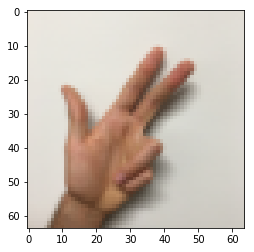

In [44]:
rand_index = np.random.randint(0,train_X.shape[0])
plt.imshow(np.squeeze(train_X[rand_index]))

### Next step is to Normalize the features and flatten the pixel values in a vector instead of having them in a 3 channel matrix.
For images dividing the pixel values by 255 is enough to normalize the values.
<br> For flattening the input features from (m, height, width, 3) to (height X width X 3, m) we will use **reshape() from numpy.** 
<br>Also correct labels vector neeeds to be converted into one hot matrix.

In [45]:
# Normalize the features
train_X = train_X/255
test_X = test_X/255

In [46]:
# Unroll/Flatten the feature vectors
train_X = train_X.reshape(train_X.shape[0], -1).T
test_X = test_X.reshape(test_X.shape[0], -1).T

# converting correct labels matrix to one hot matrix
train_y = np.eye(6)[train_y.reshape(-1)].T
test_y = np.eye(6)[test_y.reshape(-1)].T

In [47]:
print('Training set feature shape:'+ str(train_X.shape))
print('Training set labels shape:'+ str(train_y.shape))
print('Test set features shape:'+ str(test_X.shape))
print('Test set labels shape:'+ str(test_y.shape))

Training set feature shape:(12288, 1080)
Training set labels shape:(6, 1080)
Test set features shape:(12288, 120)
Test set labels shape:(6, 120)


## <u>Neural Network Architecture
<br>Input layer: 12288 features
<br>No. of Hidden Layers: 2
<br>No. of units in hidden layer: 20 in both
<br>Output Layer units: 6 (for 6 classes)

**Model:**
<br>input --> Linear --> ReLU --> Linear -->ReLU -->Linear -->Softmax(output)

In tensorflow we define blocks for the computational graph and in the end run the data through the computational graph.
<br>So for coding in tensforflow we need not worry about finding the gradients for backpropagation as all the things are systematically coded in computaional blocks, tensorflow can find the gradients for us.<br>
<br><u>**Steps:**</u>
<br>1) Create tensors 
<br>2) Define the operations to do with the tensors
<br>3) initialize the variables
<br>4) start and run the session to run the graph model

In [48]:
'''
returns the placeholders which will be required during training
Arguments:
    n_x: (int) no. of units in input layer
    n_y: (int) no. of units in output layer
returns:
    X:(tensorflow object)
    y:(tensorflow object)
'''
def createPlaceholders(n_x , n_y ):
    
    X = tf.placeholder(shape = [n_x, None], dtype = 'float')
    y = tf.placeholder(shape = [n_y, None], dtype = 'float')
  
    return X, y

### First we will initialize the weights for different layers
We will be using Xavier Initialization.


In [49]:
'''
Initializes the weights and bias values for all the layers of the neural network
Arguments:
    num_layers: (int) no. of  layer
    layer_units: (int) no. of units in output layer
returns:
    parameters:(dict) contains the weight and bias parameters
'''
def initializeParam(num_layers, layer_units):
    
    # for storing the weights and bias values of different layers
    parameters = {} 
    
    for l in range(num_layers):
        parameters['W' + str(l+1)] = tf.get_variable('W' + str(l+1), [layer_units[l+1], layer_units[l]],
                                                  initializer = tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l+1)] = tf.get_variable('b' + str(l+1), [layer_units[l+1],1],
                                                  initializer = tf.zeros_initializer())
   
    return parameters

### <u>Forward propagation


In [50]:
'''
Returns the linear output of the output layer
Arguments:
    X: (tensorflow array) input features
    parameters: (dict) weight and bias parameters of different layers
    num_layers: (int) no. of layers
    layer_units: (int) no. of units in output layer
returns:
    Z: (tf array) Returns the linear output of the output layer
'''
def forwardPropagate(X, parameters, num_layers, layer_units):
    A = X
    # for the hidden layers
    for l in range(num_layers - 1):
        Z = tf.add(tf.matmul(parameters['W' + str(l+1)], A), parameters['b' + str(l+1)])
        A = tf.nn.relu(Z)
    
    # for the output layer,we only find the linear function
    Z = tf.add(tf.matmul(parameters['W' + str(num_layers)], A), parameters['b' + str(num_layers)])
    
    return Z   

### <u>Cost function

In [51]:
'''
Returns the cost of the neural network
Arguments:
    Z3: marix containing linear output of final layer for all the examples
    y: matrix containing the correct output label for the examples
returns:
    cost: returns the cost
'''
def computeCost(Z3, y):
     
    # we will use softmax for the output layer and compute the cost function
    output_layer = tf.transpose(Z3)
    y_labels = tf.transpose(y)
    # compute the cost 
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output_layer, labels = y_labels))
    
    return cost

In [52]:
'''
Makes shuffled minibatches from the examples
Arguments:
    X: (tensorflow array) input features
    y: correct output labels for examples
    minibatch_size: (int) size of each minibatch
returns:
    mini_batches: Returns a list containing tuple pairs of feature vectors and correct output labels
'''
def getRandomMiniBatches(X, y, minibatch_size = 64):
    # total training examples
    m = X.shape[1]
    # we will store the mini batches as tuple pair in a list
    mini_batches = []
    
    ## First we need to shuffle the training examples
    permutation_list = list(np.random.permutation(m))
    shuffled_X = X[:, permutation_list]
    shuffled_y = y[:, permutation_list]
    
    # find the total no. of mini batches that can be formed from the training examples
    num_minibatches = math.floor(m/minibatch_size) 
    
    # now partition the original training set into mini batches
    # we make mini batches till the time complete mini batches can be made
    for i in range(num_minibatches):
        minibatch_X = X[:, i*minibatch_size: i*minibatch_size + minibatch_size]
        minibatch_y = y[:, i*minibatch_size: i*minibatch_size + minibatch_size]
        
        minibatch = (minibatch_X, minibatch_y)
        mini_batches.append(minibatch)
        
    # if number of minibatches that can be made is not a multiple of 'm'
    if m % num_minibatches != 0:
        minibatch_X = X[:, i*minibatch_size: m]
        minibatch_y = y[:, i*minibatch_size: m]
        
        minibatch = (minibatch_X, minibatch_y)
        mini_batches.append(minibatch)
        
    return mini_batches

### <u>Backward Propagation and Optimization
Tensorflow takes care of finding the gradients so our job is to provide it with the cost function and telling which optimizer to use.

In [53]:
'''
Runs the Neural network on training examples to get the parameter values 
Arguments:
    num_layers: no. of layers
    layer_units: list containing the no. of units in each layer
    X_train: training features fro m examples
    Y_train: correct output labels for training examples
    X_test: input features for test examples 
    Y_test:correct otuput labels for examples
    learning_rate: learning rate for optimization
    num_epochs: no. of epochs to run 
    minibatch_size = size of each mini batch
returns:
    Z: (tf array) Returns the linear output of the output layer
'''
def nnModel(num_layers, layer_units, X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 64):
    
    # this allows to rerun the model without overwriting tensorflow variables
    ops.reset_default_graph()                         
    
    # no. of training features and total no. of training examples
    (n_x, m) = X_train.shape             
    n_y = Y_train.shape[0]               
    
    # number of minibatches 
    num_minibatches = int(m / minibatch_size) 
            
    # required for keeping track of cost 
    costs = []                      
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = createPlaceholders(n_x, n_y)
    
    # initialize the parameters
    parameters = initializeParam(num_layers, layer_units)
    
    # adding the forward propagation part to the computation graph
    Z3 = forwardPropagate(X, parameters, num_layers, layer_units)
   
    # adding the cost function part to the computation graph
    cost = computeCost(Z3, Y)
    
    # Backpropagation
    # we will use Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # now we will run the neural network
    with tf.Session() as sess:
        
        # do initialization for the variables
        sess.run(init)
        
        # start training
        for epoch in range(num_epochs):
            # epoch cost 
            epoch_cost = 0.                      
            minibatches = getRandomMiniBatches(X_train, Y_train, minibatch_size)

            for curr_minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = curr_minibatch
                
                # Backward propagation can be incorporated in tensorflow by computing "optimizer" and the "cost",
                # We will give minibatch for X and y to the feed_dict
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                # add the current minbatch cost to compute the total mini batch cost
                epoch_cost += minibatch_cost / num_minibatches
            
            # printing the cost to see progress
            if epoch % 100 == 0:
                print('Cost %i: %f' % (epoch, epoch_cost))
            
            # storing the epoch cost for plotting 
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        print ("Training done")
        
        # to save the parameters in a variable
        parameters = sess.run(parameters)
        
        return parameters, costs

### Now time to do training on the neural network

In [55]:
# for calculating the time taken for computation
start = time.clock()
num_layers = 3
layer_units = [train_X.shape[0], 25, 12, 6]

learning_rate = 0.0001,
num_epochs = 1500
minibatch_size = 64

# training the model
parameters, costs = nnModel(num_layers, layer_units, train_X, train_y, test_X, test_y, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 64)
print('Time taken: ' + str((time.clock() - start)/60) + ' seconds')

Cost 0: 1.963466
Cost 100: 0.953373
Cost 200: 0.605937
Cost 300: 0.408405
Cost 400: 0.287869
Cost 500: 0.195621
Cost 600: 0.130834
Cost 700: 0.084097
Cost 800: 0.053495
Cost 900: 0.038553
Cost 1000: 0.026856
Cost 1100: 0.017250
Cost 1200: 0.010499
Cost 1300: 0.005848
Cost 1400: 0.010153
Training done
Time taken: 8.912865920979387 seconds


#### For plotting  cost vs epoch graph to see how the cost changes

In [62]:
'''
Plots cost vs Interation
Arguments:
    costs: list of cost computed during every 5th epoch
    learning_rate: learning rate of the optimization step
returns:
    nil
'''
def plotCost(costs, learning_rate):
    # plot the graph for cost changing with iterations
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

#### For calculating the accuracy of the Model

In [96]:
'''
Calculates the accuracy on training and test sets
Arguments:
    X_train: training features fro m examples
    Y_train: correct output labels for training examples
    X_test: input features for test examples 
    Y_test:correct otuput labels for examples
    num_layers: no. of layers
    layer_units: list containing the no. of units in each layer
    parameters: trained parameter values for the neural network includes weight and bias values
returns:
    nil
'''
def calculateAccuracy( X_train, Y_train, X_test, Y_test, num_layers, layer_units, parameters ):
    # no. of features
    n_x = X_train.shape[0]
    n_y = 6
    
    # placeholder for input features
    X = tf.placeholder("float", [n_x, None])
    Y = tf.placeholder("float", [n_y,None])
    
    # for storing the tf converted parameters
    tf_param = {}
    
    # convert the parameters to tf 
    for l in range(num_layers):
            tf_param['W' + str(l+1)] = tf.convert_to_tensor(parameters['W' + str(l+1)])
            tf_param['b' + str(l+1)] = tf.convert_to_tensor(parameters['b' + str(l+1)])
    
    # take the output from trained NN by doing forward propagation
    Z3 = forwardPropagate(X, tf_param, num_layers, layer_units)
    
    # Calculate the correct predictions
    corr_predictions = tf.equal(tf.argmax(Z3), tf.argmax(Y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(corr_predictions, "float"))
    with tf.Session() as sess:
        print ("Accuracy on Training set:", accuracy.eval({X: X_train, Y: Y_train})*100)
        print ("Accuracy on Test set:", accuracy.eval({X: X_test, Y: Y_test})*100)

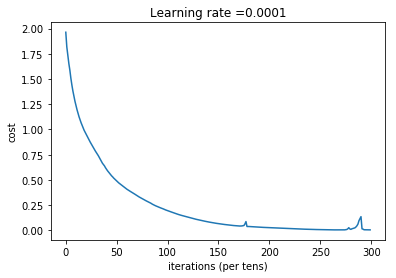

Accuracy on Training set: 100.0
Accuracy on Test set: 84.1666638851


In [97]:
learning_rate = 0.0001
plotCost(costs, learning_rate)
calculateAccuracy( train_X, train_y, test_X, test_y, num_layers, layer_units, parameters )

In [80]:
'''
for making a prediction by the neural network for an input image
Arguments:
    n_X: no. of units in input layer
    num_layers: total no. of layers
    X: input features
    parameters: trained parameter values
returns:
    preiction for the input 
'''
def doPrediction(n_x, num_layers, input_X, parameters):
    # placeholder for input features
    X = tf.placeholder("float", [n_x, None])
    
    # for storing the tf converted parameters
    tf_param = {}
    
    # convert the parameters to tf 
    for l in range(num_layers):
            tf_param['W' + str(l+1)] = tf.convert_to_tensor(parameters['W' + str(l+1)])
            tf_param['b' + str(l+1)] = tf.convert_to_tensor(parameters['b' + str(l+1)])
    
    # take the output from trained NN by doing forward propagation
    Z3 = forwardPropagate(X, tf_param, num_layers, layer_units)
    
    # take the max softmax output
    softmax_output = tf.argmax(Z3)
    
    with tf.Session() as sess:
        prediction = sess.run(softmax_output, feed_dict = {X: input_X})
        
    return prediction

In [ ]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "6.jpg"


# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = doPrediction(train_X.shape[0], 3, my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))